In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset

import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries 





from tqdm.notebook import tqdm
from tqdm.autonotebook import trange
import pickle
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool
import time


import sklearn
from sklearn.preprocessing import StandardScaler

from IPython.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))
display(HTML("<style type='text/css'>.CodeMirror{font-size: 17px;</style>"))
#https://www.kaggle.com/code/victoriamiller19/predicting-stock-prices-with-deep-neural-networks

/tmp/ipykernel_13086/804659122.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [2]:
# set all configures in one dictonary
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu') 
device
conf = { "train": { "device":device,
                    "batch_size": 64,
                    "epoch_amount": 100,
                    "lr": 0.01,
                     "train_period": 20,
                     "predict_period": 2},
        
           "train_test_split": 0.8,
        "API_key": "C9VU7XY1IGSX6HL5"
       }


In [3]:
df = pd.read_csv("/home/artur/Документы/NeuralNetTasks/datasets/StockPriceApple/AAPL.csv")
print(df.columns)
df = df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
data = df.rename(columns={'Close': "price", 'Date':"date"}).copy()
data

data_date = data["date"].copy()

print(data["price"])
data = data.set_index(np.arange(0, len(data["price"])))
data
#print(df)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
0          0.128348
1          0.121652
2          0.112723
3          0.115513
4          0.118862
            ...    
10463    131.880005
10464    132.759995
10465    135.429993
10466    130.059998
10467    131.559998
Name: price, Length: 10468, dtype: float64


,date,price
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862
...,...,...
10463,2022-06-13,131.880005
10464,2022-06-14,132.759995
10465,2022-06-15,135.429993
10466,2022-06-16,130.059998


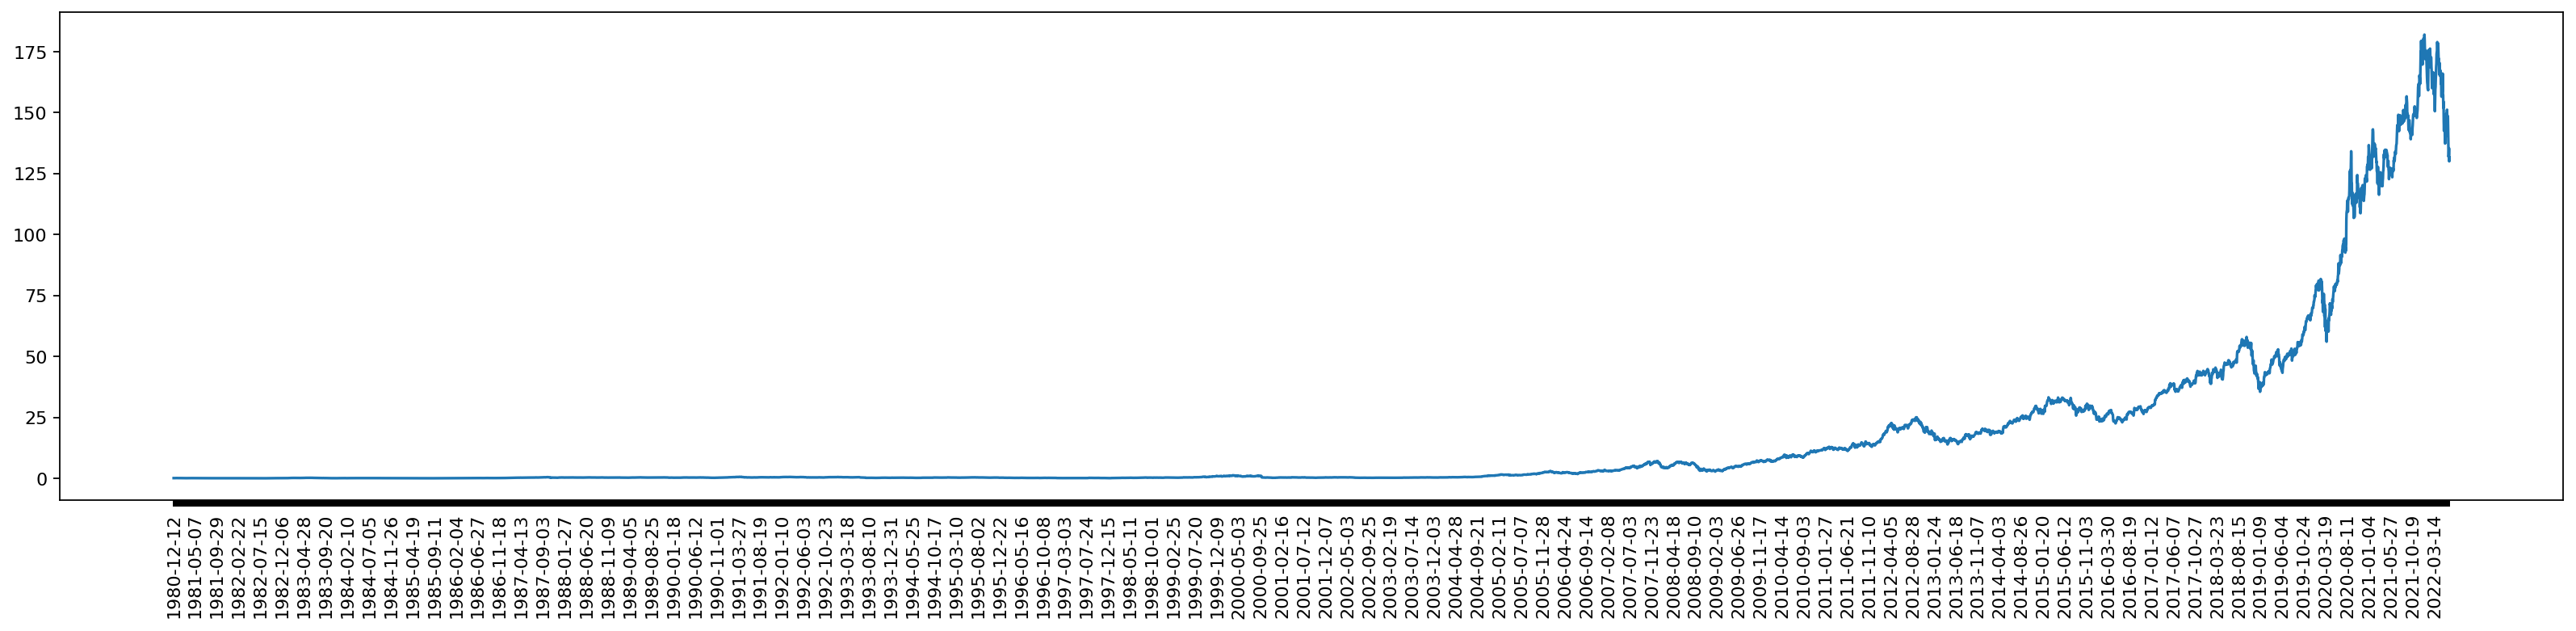

In [4]:
fig = plt.figure(figsize=(25, 5), dpi=160)
plt.plot(np.arange(0, len(data["price"])), data["price"], "-")

xticks_value = [data_date[i] if i %100 == 0 else None for i in range(len(data["price"]))];
xtv = np.arange(0,len(xticks_value));

plt.xticks(xtv, xticks_value, rotation='vertical');


In [5]:
# =====================================
# =========download data (my version)============================
# =====================================

# download data from TimeSeries
#ts = TimeSeries(key=conf["API_key"], output_format='pandas')
#data, _ = ts.get_daily_adjusted(symbol='IBM', outputsize='full')

# I have date indexes, I want to make from this indexes to columns
#data.reset_index(inplace=True)

#print(data1["8. split coefficient"].unque())
#data = data.drop(columns=['1. open', '2. high', '3. low', '5. adjusted close', '6. volume', '7. dividend amount'])
#data = data.rename(columns = {"date":"date", "4. close": "price", "8. split coefficient": "split"})

#k = 1
#bool_list = data["split"]!= 1.
#divination = np.ones(len(bool_list))
#for i in range(len(data["split"])):
#    el = bool_list[i]
#    if el == False:
#        divination[i] /= k
#        continue
#    else:
#        k *= data["split"][i]
#        print(k)
#        divination[i] /= k

#divination = pd.DataFrame(divination)

#data["price"] *= divination[divination.keys()[0]]
#data["price"] *= data["split"]
#data = data.iloc[::-1]
#data = data.set_index(np.arange(0, len(data["price"])))


In [8]:
# creating the numpy array of high price 
high_price = data["price"].to_numpy()
data_date =  data["date"].tolist()

    

In [ ]:
# download data from TimeSeries
#ts1 = TimeSeries(key=conf_my["API_key"])
#data1, _ = ts1.get_daily_adjusted(symbol='AAPL', outputsize='full')
#data_date = [date for date in data1.keys()]
#data_date.reverse()
#print(data_date)


## Data preparing

in this cell I performed data normalization and test division of the train dataset

1. I made the data normalization by this equation:

$$\mathbf{x_i}^{\text{new}} = \frac{\mathbf{x_i} - \mu_i}{\sigma_i}$$

2. I performed divination of the train dataset by **Rolling Window** method

In this project i will train the model to prection ***n *** days price based on the past ***20*** days. 






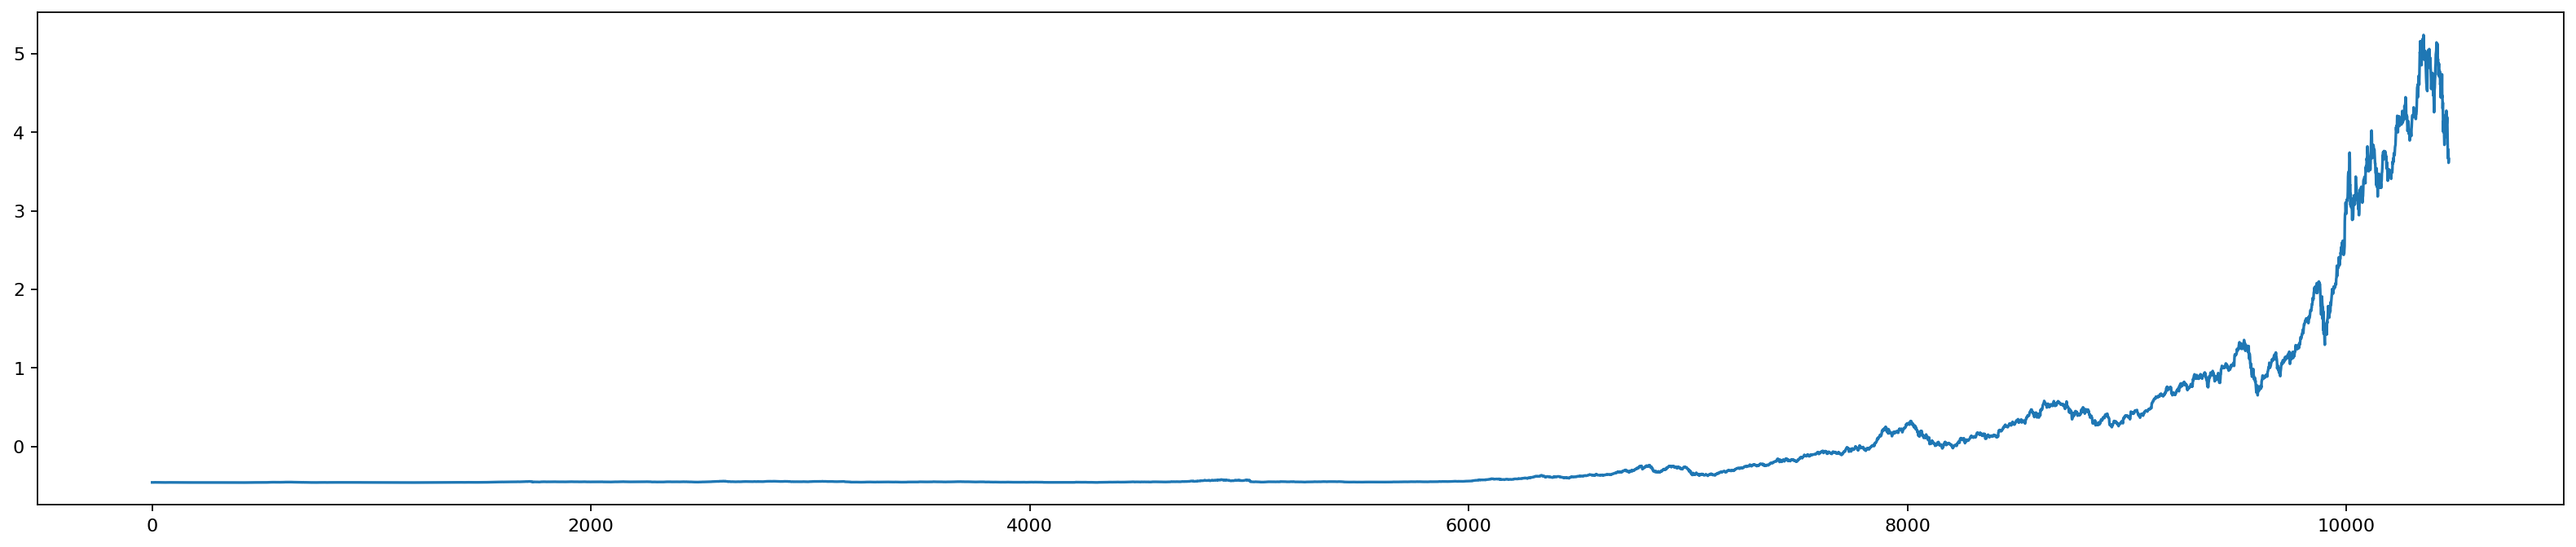

In [9]:
# ======================================
# ================normalization======================
# ======================================

def normalization(x):
    mu = x.mean()
    std = x.std()
    x_normalization = (x - mu) / std
    return x_normalization

data_norm = normalization(high_price)

fig = plt.figure(figsize=(25, 5), dpi=160)
plt.plot(np.arange(0, len(data_norm)), data_norm, "-")

#xticks_value = [data_date[i] if i %100 == 0 else None for i in range(len(data_norm))  ]
#xtv = np.arange(0,len(xticks_value))
#plt.xticks(xtv, xticks_value, rotation='vertical')



In [10]:
print(data_norm.shape)
print(data_norm)

(10468,)
[-0.4583814  -0.45859113 -0.45887079 ...  3.77933463  3.61114366
  3.65812442]


In [11]:
# ======================================
# ================test train======================
# ======================================
print(conf.keys())
print(conf["train"].keys())
window_size = 20
step = 7
amount_days_predicted = 1
indices_pred_stock = []
def RollingWindow(data, window_size, amount_days_predicted):
    x_train = []
    y_train = []
    for i in range(len(data) - window_size - amount_days_predicted-150):
        x_train.append(data[i:i+window_size])
        if amount_days_predicted == 1:
            y_train.append(data[i+window_size])
        else:
            y_train.append(data[i+window_size: i + window_size + amount_days_predicted])
        indices_pred_stock.append(i+window_size)
    return np.array(x_train), np.array(y_train)
X_train, y_train = RollingWindow(data_norm, window_size, amount_days_predicted)


#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

(X_train, X_val, y_train, y_val, indices_train, indices_test) = train_test_split(X_train, y_train, indices_pred_stock, test_size=0.5, random_state=42)


dict_keys(['train', 'train_test_split', 'API_key'])
dict_keys(['device', 'batch_size', 'epoch_amount', 'lr', 'train_period', 'predict_period'])


In [12]:
print(X_train.shape)
print(y_train.shape)
print(len(indices_train))

(5148, 20)
(5148,)
5148


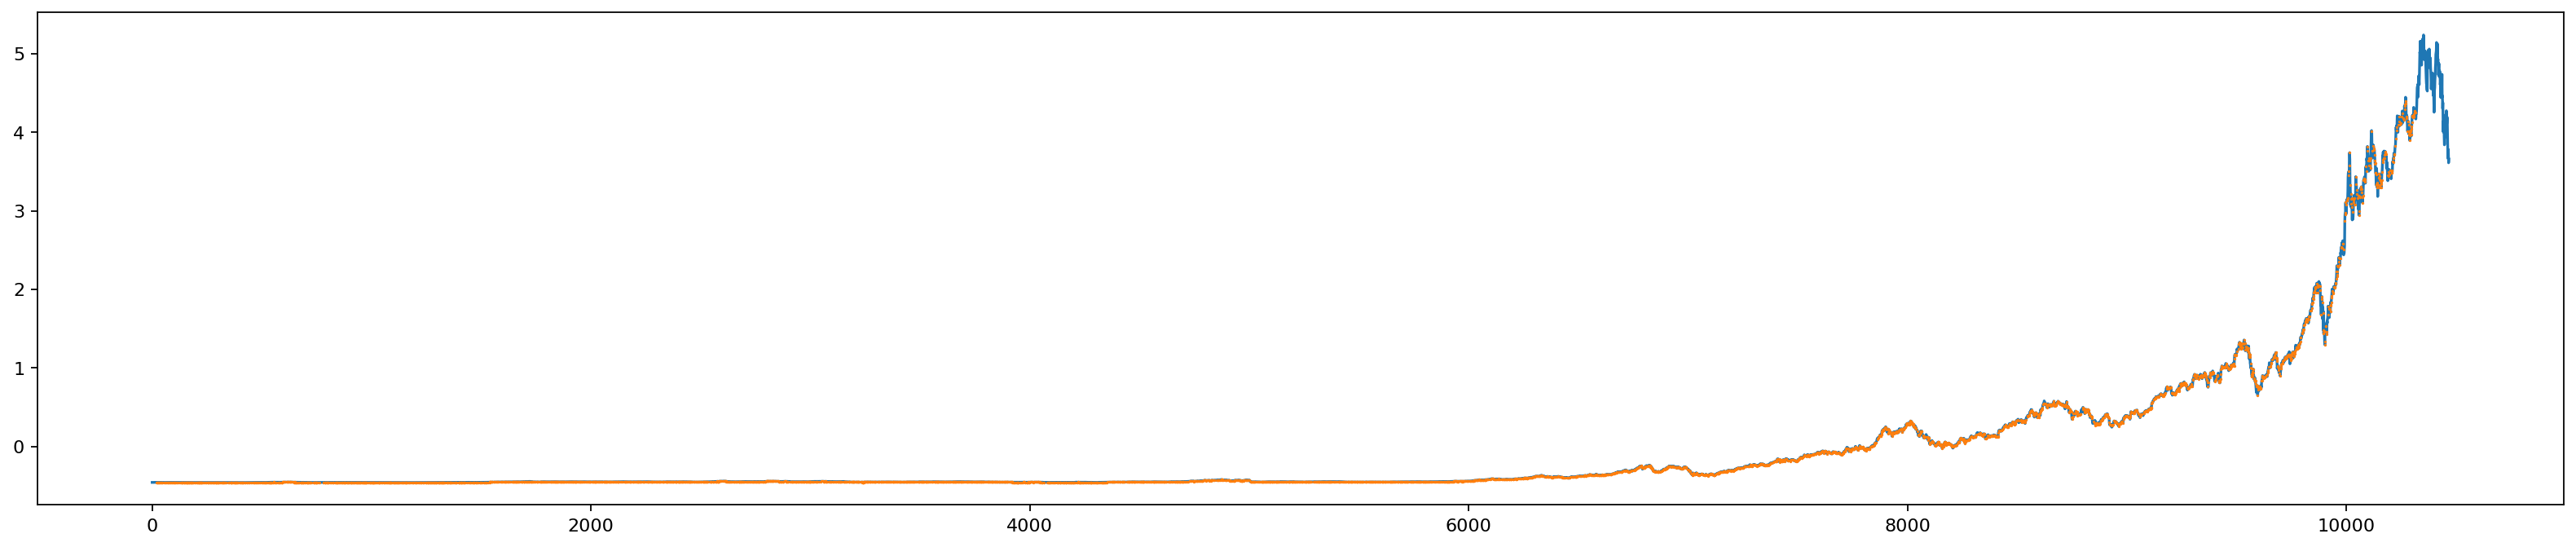

In [13]:

fig = plt.figure(figsize=(25, 5), dpi=160)
plt.plot(np.arange(0, len(data_norm)), data_norm, "-")
plt.plot(indices_train, y_train, ".", markersize = "1")

#xticks_value = [data_date[i] if i %100 == 0 else None for i in range(len(data_norm))  ]
#xtv = np.arange(0,len(xticks_value))
#plt.xticks(xtv, xticks_value, rotation='vertical')


In [14]:
# prepare data: make the tensore and dataloader

X_train_t = torch.tensor(X_train)
y_train_t = torch.tensor(y_train)

X_val_t = torch.tensor(X_val)
y_val_t =  torch.tensor(y_val)

print(X_train_t.size())

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)

torch.Size([5148, 20])


In [30]:
# ====================================
# ============ MODEL ========================
# ====================================

class LinerSimpleModel(nn.Module):
    def __init__(input_size=window_size, output_size=1, hidden_size=32):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
    def forward(x):
        x1 = nn.relu(self.fc1(x))
        x2 = nn.relu(self.fc2(x1))
        x3 = self.fc3(x2)
        return x3
        
    

In [31]:


device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu') 
device
model =  LinerSimpleModel(window_size)
# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)


    
    

TypeError: empty(): argument 'size' must be tuple of ints, but found element of type LinerSimpleModel at pos 2

In [ ]:

# ===========================================
# 3) Train loop
# ===========================================

#trainig loop:
  #forward pass: compute prediction and loss
  #backward pass: compute gradient (from optimizer)
  #update weigths

def TrainLoop(model, optimizer, loss_fun, train_dataloader, val_dataloader, epochs, device):
    train_losses = [] 
    val_losses = [] 
    
    for epoch in range(epochs):
        model.train()
        sum_loss = 0
        for x_batch, y_batch in train_dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            # forward pass: y_pred and loss and loss backward
            y_pred  = model(x_batch)
            loss = loss_fun(y_pred, y_batch)
            sum_loss += loss
            loss.backward()
            
            #bacward pass: optimizer step, zero gradient
            optimizer.step()
            optimizer.zero_grad()
        train_losses.append(sum_loss / len(train_dataloader))
        
        
        # part for loss in validation dataset
        loss_sum = 0
        correct = 0
        num = 0
        print(epoch)
        model.eval()
        
        for x_val, y_val in val_dataloader:
            with torch.no_grad():
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                
                y_pred = model(x_val)
                loss = loss_fun(y_pred, y_val)
                loss_sum += loss
                
        val_losses.append(loss_sum / len(test_dataloader))
    return train_losses, val_losses
        
    
    
    
    
    